In [5]:
!pip install openpyxl

In [6]:
!pip install xgboost

In [19]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [8]:
# Step 2: Load the Data
file_path = '/content/Stock Price Dataset.csv'  # Update the file path if necessary
data = pd.read_csv(file_path)

In [9]:
# Checking for missing values
print(data.isnull().sum())

# Checking data types
print(data.dtypes)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [10]:
# Step 4: Feature Engineering
# Adding moving averages
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# Adding RSI (Relative Strength Index)
def RSI(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI'] = RSI(data['Close'])

In [11]:
# Dropping rows with NaN values after feature engineering
data.dropna(inplace=True)

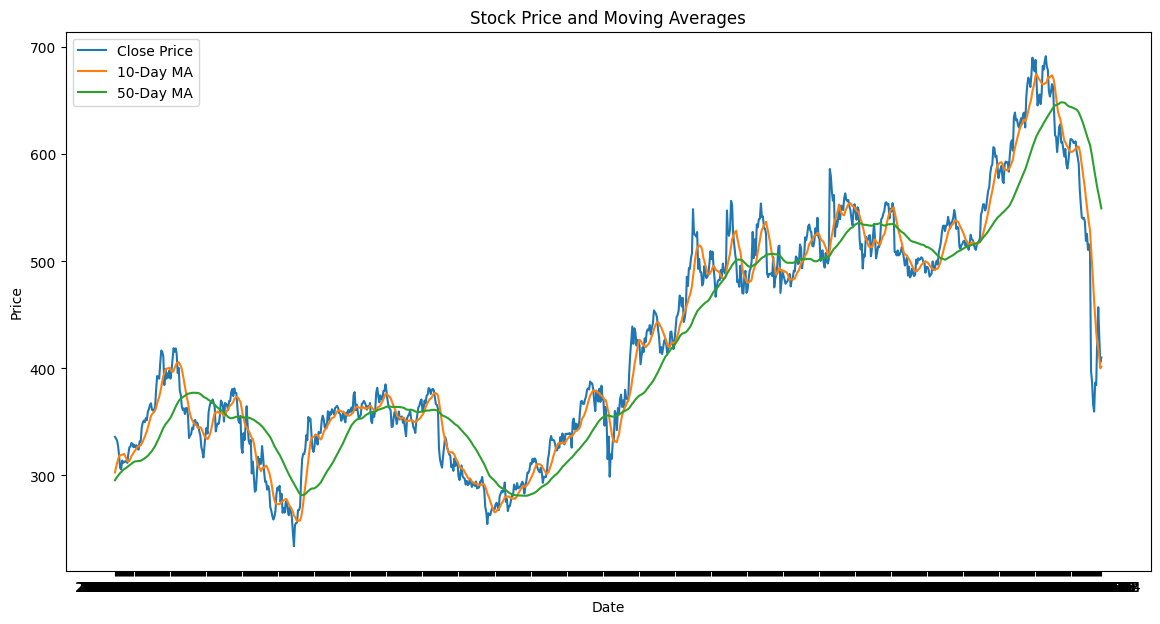

In [12]:
# Step 5: Exploratory Data Analysis (EDA)
# Plotting the closing price and moving averages
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], data['MA10'], label='10-Day MA')
plt.plot(data['Date'], data['MA50'], label='50-Day MA')
plt.title('Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


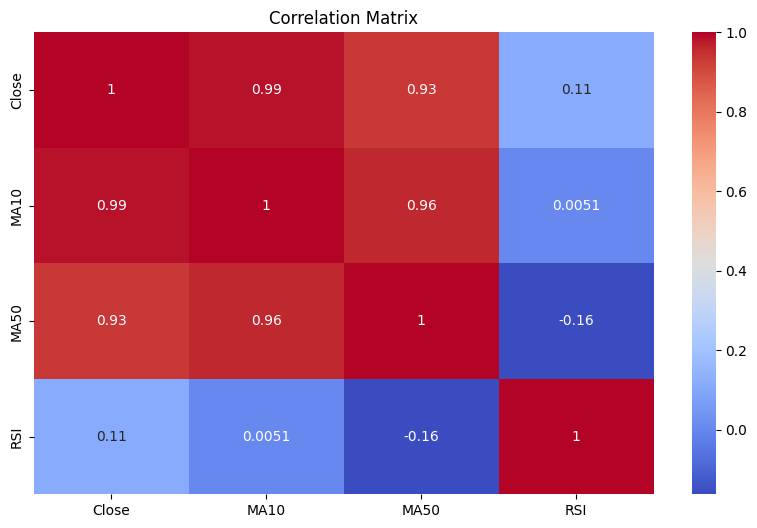

In [13]:
# Correlation analysis
plt.figure(figsize=(10, 6))
sns.heatmap(data[['Close', 'MA10', 'MA50', 'RSI']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [14]:
# Step 6: Model Development
# Selecting features and target variable
features = ['MA10', 'MA50', 'RSI']
X = data[features]
y = data['Close']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
# Step 3: Define a function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return pd.Series({'Model': model_name, 'MAE': mae, 'RMSE': rmse})

In [20]:
# Step 4: Train and evaluate each model
results = []

# Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_lr, 'Linear Regression'))

# Model 2: Decision Tree Regressor
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_dt, 'Decision Tree Regressor'))

# Model 3: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest Regressor'))

# Model 4: Support Vector Regressor (SVR)
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_svr, 'Support Vector Regressor'))

# Model 5: XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_xgb, 'XGBoost Regressor'))


In [21]:
# Step 5: Compare the results
results_df = pd.DataFrame(results)
results_df.sort_values(by='RMSE', ascending=True, inplace=True)

# Display the comparison results
print(results_df)


                      Model        MAE       RMSE
4         XGBoost Regressor   8.439125  12.179816
2   Random Forest Regressor   8.484281  13.197738
0         Linear Regression  10.706531  14.906116
1   Decision Tree Regressor  10.657918  16.679773
3  Support Vector Regressor  30.820830  52.293769


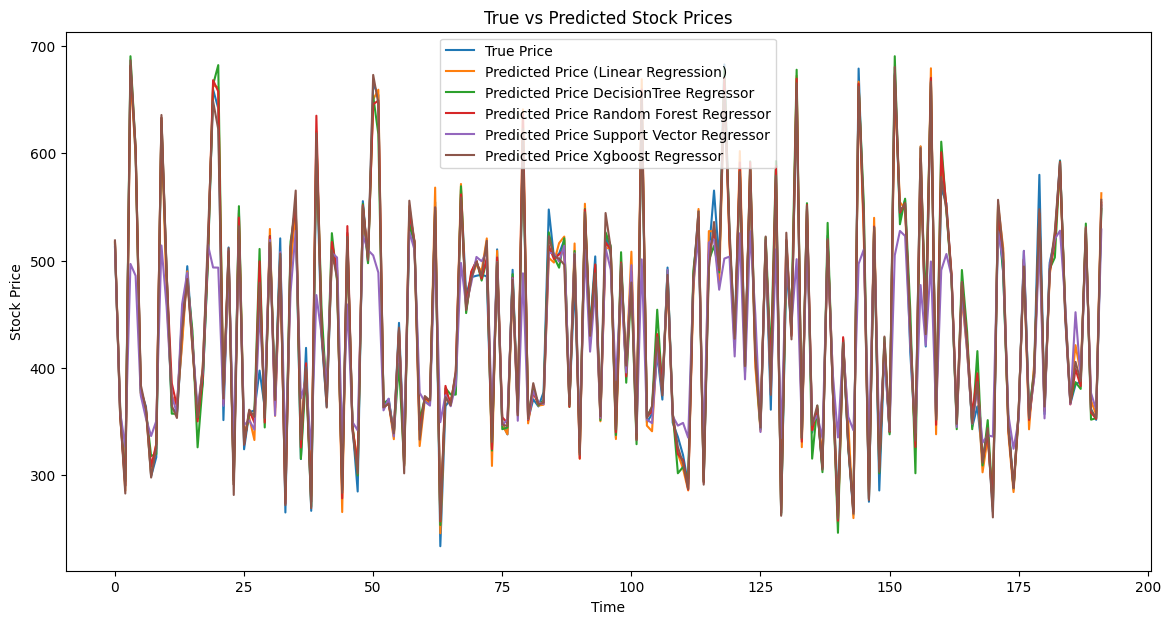

In [22]:
# Step 7: Plotting Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='True Price')
plt.plot(y_pred_lr, label='Predicted Price (Linear Regression)')
plt.plot(y_pred_dt, label='Predicted Price DecisionTree Regressor')
plt.plot(y_pred_rf, label='Predicted Price Random Forest Regressor')
plt.plot(y_pred_svr, label='Predicted Price Support Vector Regressor')
plt.plot(y_pred_xgb, label='Predicted Price Xgboost Regressor')
plt.title('True vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

<ipython-input-23-98493ec3dbaa>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results_df, palette='viridis')


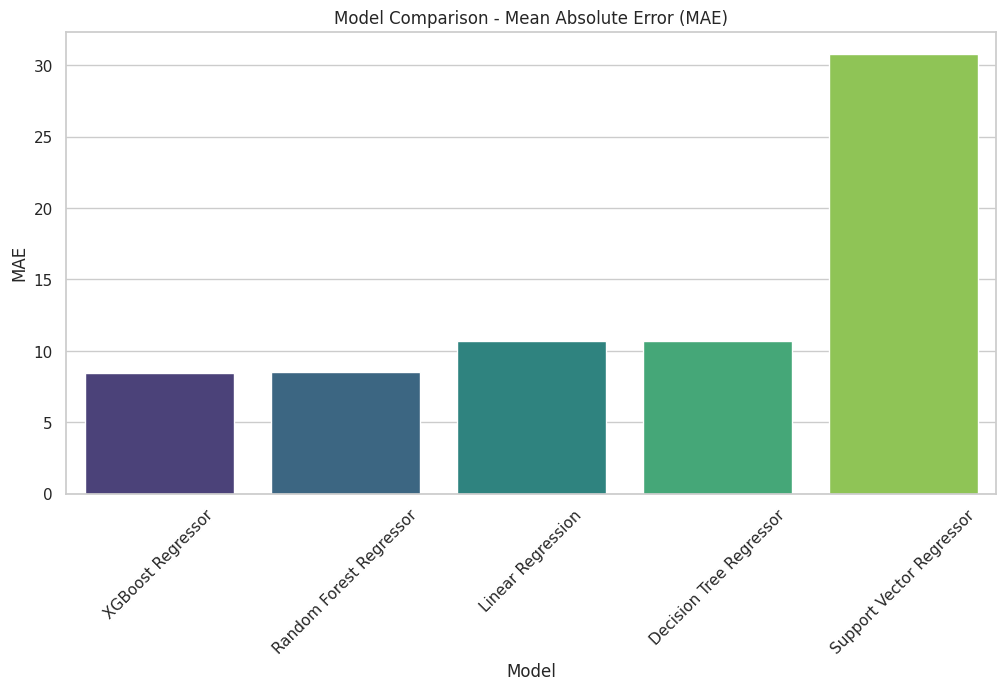

<ipython-input-23-98493ec3dbaa>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df, palette='magma')


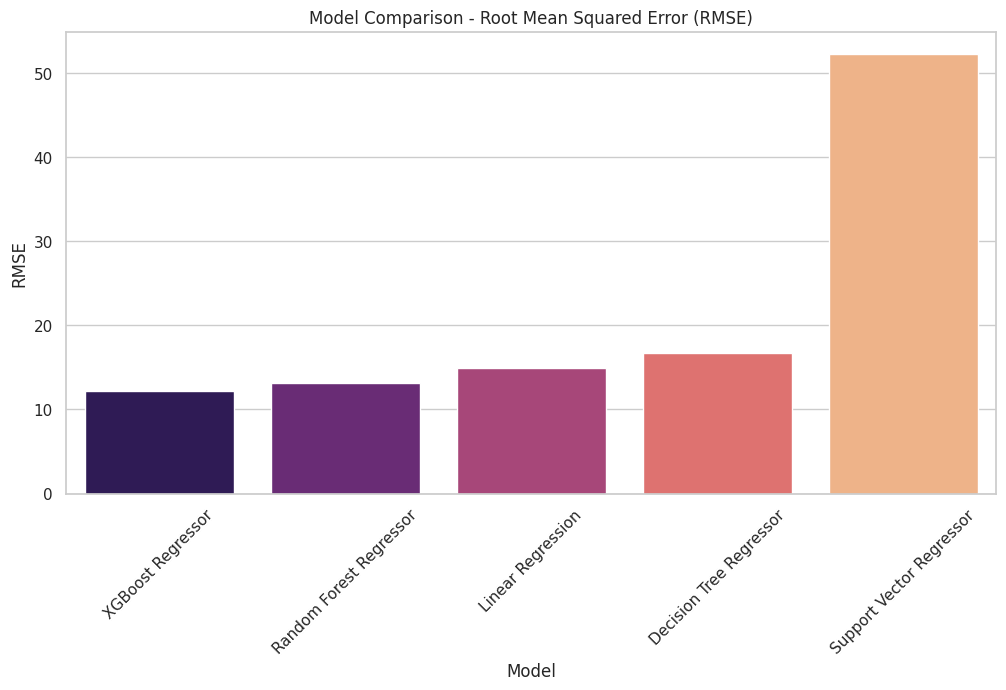

In [23]:
sns.set(style="whitegrid")

# Create a bar plot for MAE
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MAE', data=results_df, palette='viridis')
plt.title('Model Comparison - Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

# Create a bar plot for RMSE
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='magma')
plt.title('Model Comparison - Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()
